In [2]:
import pandas as pd
import numpy as np
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

data = pd.read_excel('data_lz.xlsx')
columns = data.columns
train_data, test_data = train_test_split(data, test_size=0.15, random_state=1)

# 定义需要设置的约束范围
constraints = {
    'Ele': [100, 700],
    'Cap': [150, 1000],
    'Num': [1, 8],
    'Oper_Year': [1, 22],
    'Avg_Temp': [0, 27],
    'Precip': [50, 2300],
    'Pop': [5, 1800],
    'Built_Area': [10, 1800],
    'GDP': [200, 50000],
    'GDP_Growth': [-5, 25],
    'Tert_Share': [20, 90],
    'Retail_Sale': [500000, 200000000],
    'Gas_Supply': [0, 2500000],
    'BA_Rate': [0.1, 0.6]
}

# 使用MinMaxScaler进行标准化
scaler = MinMaxScaler()

# 将数据中的每一列进行缩放
scaled_data = pd.DataFrame(scaler.fit_transform(train_data), columns=data.columns)

# 训练CTGAN模型
ctgan = CTGAN()
ctgan.fit(scaled_data, epochs=100)  # 这里的epochs可以根据需要进行调整

# 生成增强数据（例如生成1000个新样本）
generated_data = ctgan.sample(100)

# 对生成的数据进行逆缩放，恢复到原始范围
generated_data = scaler.inverse_transform(generated_data)

# 将生成的数据转回DataFrame格式
generated_data_df = pd.DataFrame(generated_data, columns=data.columns)

# 应用约束范围（确保每个生成的样本都在约束范围内）
for column, (lower, upper) in constraints.items():
    generated_data_df[column] = generated_data_df[column].clip(lower, upper)


# # 显示增强后的数据
# import ace_tools as tools; tools.display_dataframe_to_user(name="Enhanced Data", dataframe=generated_data_df)

# 保存增强后的数据
generated_data_df.to_csv('augmented_data.csv', index=False)

print("增强后的数据已保存到 'augmented_data.csv' 文件中")


c:\Users\zy\anaconda3\envs\myenv\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ..\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


增强后的数据已保存到 'augmented_data.csv' 文件中


In [11]:
import optuna
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
# import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 设置随机种子
seed = 42
# torch.manual_seed(seed)  # PyTorch的CPU生成的随机数种子
# torch.cuda.manual_seed(seed)  # PyTorch的GPU生成的随机数种子
# torch.cuda.manual_seed_all(seed)  # PyTorch的所有GPU生成的随机数种子（如果有多个GPU）

np.random.seed(seed)  # Numpy的随机数种子
random.seed(seed)  # Python的随机数种子

# # 使得数据加载时的乱序一致
# torch.backends.cudnn.deterministic = True  # 保证每次结果一致
# torch.backends.cudnn.benchmark = False  # 在固定输入数据下，禁用自动优化

data = pd.read_excel('data_lz.xlsx')
columns = data.columns
# 假设 data 已经加载，并且目标变量在最后一列
label = data.columns[-1]

# 划分训练集和测试集（可以适当调整比例）
train_data, test_data = train_test_split(data, test_size=0.15, random_state=1)
train_data_new=pd.read_csv("augmented_data.csv")
train_final =pd.concat([train_data, train_data_new], axis=0)
# 分离特征和目标变量
X_train = train_final.drop(columns=label)
y_train = train_final[label]
X_test = test_data.drop(columns=label)
y_test = test_data[label]

# 仅对数值型特征进行归一化
numeric_features = X_train.select_dtypes(include='number').columns.tolist()
scaler_X = MinMaxScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler_X.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler_X.transform(X_test[numeric_features])

# 归一化目标变量（注意：MinMaxScaler 需要二维输入）
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# 将数据转换为 PyTorch 张量
# X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


In [59]:

# 训练与优化模型的函数
def objective_xgb(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 1e3),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 1e3)
    }
    model = XGBRegressor(**param)
    model.fit(X_train_scaled, y_train_scaled)
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test_scaled, preds)
    return r2

def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    model = RandomForestRegressor(**param)
    model.fit(X_train_scaled, y_train_scaled)
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test_scaled, preds)
    return r2

def objective_gbr(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    }
    model = GradientBoostingRegressor(**param)
    model.fit(X_train_scaled, y_train_scaled)
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test_scaled, preds)
    return r2

def objective_lgbm(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
    }
    model = lgb.LGBMRegressor(**param)
    model.fit(X_train_scaled, y_train_scaled)
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test_scaled, preds)
    return r2

def objective_catboost(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 50, 500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1e3),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }
    model = cb.CatBoostRegressor(**param, verbose=0)
    model.fit(X_train_scaled, y_train_scaled)
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test_scaled, preds)
    return r2

def objective_svr(trial):
    param = {
        'C': trial.suggest_loguniform('C', 1e-2, 1e2),
        'epsilon': trial.suggest_uniform('epsilon', 0.01, 0.1),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
    }
    model = SVR(**param)
    model.fit(X_train_scaled, y_train_scaled)
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test_scaled, preds)
    return r2

def objective_knn(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 50),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),
    }
    model = KNeighborsRegressor(**param)
    model.fit(X_train_scaled, y_train_scaled)
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test_scaled, preds)
    return r2

# 神经网络优化
def objective_nn(trial):
    param = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 100)]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'solver': trial.suggest_categorical('solver', ['adam', 'lbfgs']),
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),  # L2正则化
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
        'max_iter': trial.suggest_int('max_iter', 200, 1000),  # 控制最大迭代次数（类似于 epoch）
        # 'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),  # 早期停止
    }
    
    # 初始化并训练神经网络
    model = MLPRegressor(**param)
    model.fit(X_train_scaled, y_train_scaled)
    
    # 预测
    preds = model.predict(X_test_scaled)
    
    # 计算R²
    r2 = r2_score(y_test_scaled, preds)
    
    return r2


# 使用Optuna进行优化
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)

study_gbr = optuna.create_study(direction='maximize')
study_gbr.optimize(objective_gbr, n_trials=100)

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=100)

study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=100)

study_svr = optuna.create_study(direction='maximize')
study_svr.optimize(objective_svr, n_trials=100)

study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=100)

study_nn = optuna.create_study(direction='maximize')
study_nn.optimize(objective_nn, n_trials=100)


[I 2025-02-22 17:53:39,752] A new study created in memory with name: no-name-411e4a9a-e9f1-4f38-bb5f-f7d8c9743190
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-02-22 17:54:41,633] Trial 25 finished with value: 0.6296422219703588 and parameters: {'learning_rate': 0.012789022725376853, 'max_depth': 5, 'num_leaves': 88, 'n_estimators': 446, 'subsample': 0.8879330818472663, 'colsample_bytree': 0.9112252685740472}. Best is trial 23 with value: 0.6320131614144633.
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ip

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-22 17:54:41,796] Trial 27 finished with value: 0.6283040992081945 and parameters: {'learning_rate': 0.021888970172507134, 'max_depth': 5, 'num_leaves': 91, 'n_estimators': 454, 'subsample': 0.8352080711596893, 'colsample_bytree': 0.8137507292063672}. Best is trial 23 with value: 0.6320131614144633.
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ip

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-02-22 17:54:42,440] Trial 36 finished with value: 0.6232218037211621 and parameters: {'learning_rate': 0.012757458555209688, 'max_depth': 4, 'num_leaves': 87, 'n_estimators': 324, 'subsample': 0.6863025072610665, 'colsample_bytree': 0.8715274791283824}. Best is trial 32 with value: 0.6397904590031906.
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ip

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-02-22 17:54:43,191] Trial 49 finished with value: 0.5900622482367344 and parameters: {'learning_rate': 0.049065862365725, 'max_depth': 3, 'num_leaves': 96, 'n_estimators': 236, 'subsample': 0.6303806479826649, 'colsample_bytree': 0.7091809224005321}. Best is trial 45 with value: 0.6625700501422582.
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipyke

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-02-22 17:54:44,013] Trial 66 finished with value: 0.6060694479946767 and parameters: {'learning_rate': 0.046843289101386826, 'max_depth': 3, 'num_leaves': 92, 'n_estimators': 174, 'subsample': 0.6099798596721552, 'colsample_bytree': 0.6778935844666767}. Best is trial 45 with value: 0.6625700501422582.
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ip

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-02-22 17:54:44,454] Trial 75 finished with value: 0.6273943288373711 and parameters: {'learning_rate': 0.05917724247593832, 'max_depth': 4, 'num_leaves': 89, 'n_estimators': 176, 'subsample': 0.691978608423003, 'colsample_bytree': 0.7358690494847353}. Best is trial 45 with value: 0.6625700501422582.
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipyk

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-02-22 17:54:45,345] Trial 91 finished with value: 0.6275680656165423 and parameters: {'learning_rate': 0.06422920863776435, 'max_depth': 5, 'num_leaves': 94, 'n_estimators': 264, 'subsample': 0.6842532853224741, 'colsample_bytree': 0.6286470007165883}. Best is trial 45 with value: 0.6625700501422582.
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipy

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:56: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:57: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
c:\Users\zy\anaco

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:69: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\1126372931.py:70: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1e3),
[I 2025-02-22 17:54:46,609] Trial 0 finished with value: 0.7549607726602072 and parameters: {'iterations': 471, 'depth': 6, 'learning_rate': 0.033810416550383755, 'l2_leaf_reg': 0.27014574455407087, 'border_count': 124}. Best is trial 0 with value: 0.7549607726602072.
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\11

In [60]:

# 获取最优超参数并评估
models = {
    'XGBoost': XGBRegressor(**study_xgb.best_params),
    'Random Forest': RandomForestRegressor(**study_rf.best_params),
    'Gradient Boosting': GradientBoostingRegressor(**study_gbr.best_params),
    'LightGBM': lgb.LGBMRegressor(**study_lgbm.best_params),
    'CatBoost': cb.CatBoostRegressor(**study_catboost.best_params, verbose=0),
    'SVM': SVR(**study_svr.best_params),
    'KNN': KNeighborsRegressor(**study_knn.best_params),
    'Neural Network': MLPRegressor(**study_nn.best_params)
}

# 存储训练集和测试集的 R² 结果
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled)
    
    # 训练集和测试集的预测
    train_preds = model.predict(X_train_scaled)
    test_preds = model.predict(X_test_scaled)
    
    # 计算 R²
    train_r2 = r2_score(y_train_scaled, train_preds)
    test_r2 = r2_score(y_test_scaled, test_preds)
    
    # 存储结果
    results.append({
        'Model': name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Best Hyperparameters': str(model.get_params())
    })


c:\Users\zy\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\zy\anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?
c:\Users\zy\anaconda3\envs\myenv\lib\site-packages\lightgbm\basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 13
[LightGBM] [Info] Start training from score 0.312048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

c:\Users\zy\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\zy\anaconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 创建DataFrame并显示结果
df_results = pd.DataFrame(results)
df_results.to_csv("model_results_origin.csv")

In [177]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 创建DataFrame并显示结果
df_results = pd.DataFrame(results)
df_results.to_csv("model_results_100.csv")


In [62]:
import joblib
final_model = cb.CatBoostRegressor(**study_catboost.best_params)
# 
joblib.dump(final_model, 'origin_best_model.joblib')

['origin_best_model.joblib']

In [14]:
import joblib
catboost_model = joblib.load('final_model.joblib')

In [15]:
catboost_model.fit(X_train_scaled, y_train_scaled)
# 训练集和测试集的预测
train_preds = catboost_model.predict(X_train_scaled)
test_preds = catboost_model.predict(X_test_scaled)

# 计算 R²
train_r2 = r2_score(y_train_scaled, train_preds)
test_r2 = r2_score(y_test_scaled, test_preds)

# 存储结果
print({
    'Model': "xgboost_model",
    'Train R²': train_r2,
    'Test R²': test_r2,
    # 'Best Hyperparameters': str(xgboost_model.get_params())
})

AttributeError: 'XGBModel' object has no attribute 'feature_weights'

In [ ]:
results

In [15]:
data_lz_new = pd.read_excel("data_lz_new.xlsx")
# 选择数值型特征列
numeric_features_new_data = data_lz_new.select_dtypes(include='number').columns.tolist()

# 对新数据进行归一化
X_new_data_scaled = data_lz_new.copy()
X_new_data_scaled[numeric_features_new_data] = scaler_X.transform(data_lz_new[numeric_features_new_data])
# 预测训练过的模型结果
xgboost_predictions = xgboost_model.predict(X_new_data_scaled)

# 反归一化预测结果
xgboost_predictions_actual = scaler_y.inverse_transform(xgboost_predictions.reshape(-1, 1))
# 你可以反归一化其他模型的预测结果
# 将预测结果保存为 DataFrame
predictions_df = pd.DataFrame({
    'XGBoost Predictions': xgboost_predictions_actual.flatten(),
})

# 保存到 CSV 文件
predictions_df.to_csv('predictions.csv', index=False)


In [66]:
# 确保 X_test 是 NumPy 数组，否则先转换
X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test



# 如果 X_test 是 DataFrame 且想保留列名
# predictions_df = pd.DataFrame({
#     'XGBoost Predictions': xgboost_predictions_new1_1d,
#     "Origin_test": X_test.iloc[:, 0].values  # 使用 .iloc 获取第一列
# })
xgboost_predictions_new = catboost_model.predict(X_test_scaled)

# 反归一化预测结果
xgboost_predictions_new = scaler_y.inverse_transform(xgboost_predictions_new.reshape(-1, 1))
xgboost_predictions_new1 = np.array(xgboost_predictions_new).reshape(-1,1)
xgboost_predictions_new1_1d = xgboost_predictions_new1.flatten() # Flatten to 1D

# 你可以反归一化其他模型的预测结果
# 将预测结果保存为 DataFrame
predictions_df = pd.DataFrame({
    'XGBoost Predictions': xgboost_predictions_new1_1d,
    "Origin_test": y_test  # 现在使用正确的数组索引方式
})

# 保存到 CSV 文件
predictions_df.to_csv('predictions_0.csv', index=False)

In [16]:
# 绘制训练集和测试集的 R² 对比图
x = np.arange(len(models))  # 模型的索引
width = 0.35  # 每个条形图的宽度

# 绘制训练集 R² 和测试集 R²
plt.figure(figsize=(10, 6), dpi=600)
plt.bar(x - width / 2, model_results_train.values(), width, label='训练集 R2')
plt.bar(x + width / 2, model_results_test.values(), width, label='测试集 R2')

plt.xlabel('模型')
plt.ylabel("R2")
plt.title('不同模型在训练集和测试集上的 R2对比')
plt.xticks(x, model_results_train.keys(), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'model_results_train' is not defined

<Figure size 6000x3600 with 0 Axes>

In [6]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
plt.rcParams['axes.unicode_minus'] = False  # Ensure the correct display of minus signs
from sklearn.ensemble import RandomForestRegressor


data_lz_new = pd.read_excel("data_lz_new.xlsx")
# 使用 SHAP 进行模型解释
explainer = shap.Explainer(xgboost_model)



In [24]:
X_train_scaled

,Ele,Cap,Num,Oper_Year,Avg_Temp,Precip,Pop,Built_Area,GDP,GDP_Growth,Tert_Share,Retail_Sale,Gas_Supply
29,0.448000,0.294118,0.076923,0.263158,0.160360,0.429914,0.056825,0.033722,0.009442,0.304723,0.598497,0.006776,0.002797
16,0.376550,0.529412,0.000000,0.105263,0.443484,0.256777,0.174930,0.049050,0.101133,0.357290,0.470874,0.055314,0.006693
110,0.672281,0.235294,1.000000,0.842105,0.668010,0.639912,0.344290,0.288780,0.543769,0.544148,0.490291,0.450478,0.070272
155,0.489782,0.823529,0.384615,0.315789,0.565563,0.720048,0.301950,0.347639,0.332424,0.371663,0.575478,0.260313,0.054132
158,0.456591,0.294118,0.076923,0.473684,0.157766,0.388467,0.028412,0.029430,0.007269,0.342094,0.589101,0.003955,0.001949
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.438104,0.378791,0.085360,0.052632,0.526659,0.213671,0.226268,0.152804,0.459393,0.157017,0.283257,0.083196,0.003388
96,0.628605,0.501409,0.087957,0.149685,0.700252,0.296090,0.398142,0.068398,0.359394,0.130584,0.361887,0.088875,0.000000
97,0.601874,0.135245,0.164696,0.105345,0.596578,0.385430,0.209858,0.264557,0.083088,0.422263,0.289508,0.097981,0.000000
98,0.656829,1.000000,0.054412,0.198117,0.389726,0.152338,0.980147,0.248572,0.000000,0.607573,0.221139,0.223980,0.000000


C:\Users\zy\AppData\Local\Temp\ipykernel_35416\3000134146.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color=plt.cm.get_cmap("GnBu"),  # 使用从紫色到黄色的渐变色
C:\Users\zy\AppData\Local\Temp\ipykernel_35416\3000134146.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


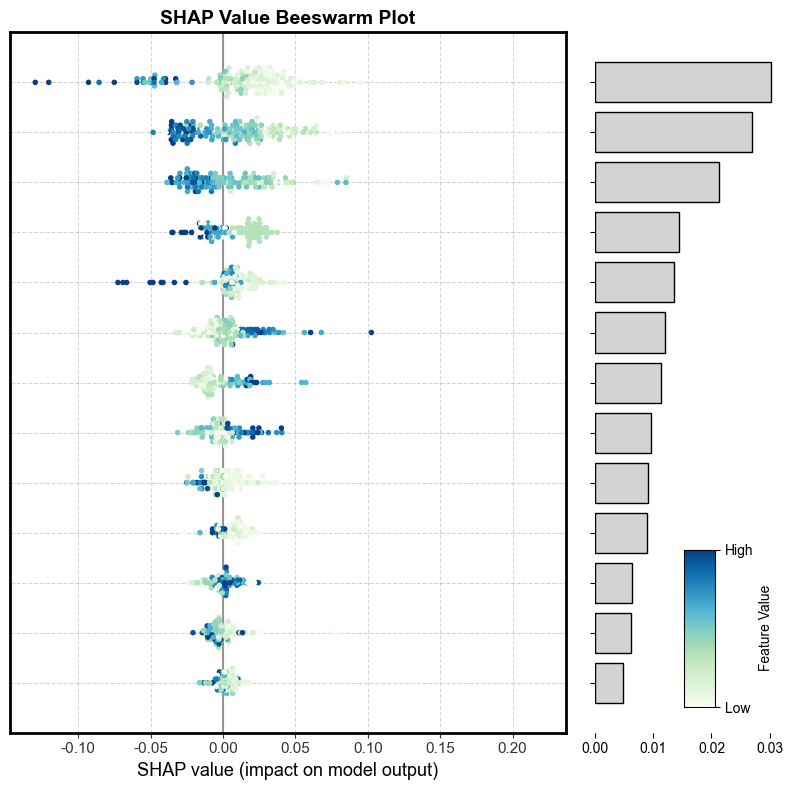

In [37]:

plt.rcParams['font.sans-serif'] = ['Arial']  
shap_values = explainer(X_train_scaled.iloc[:150,:])

# 定义特征名称，假设你有一个类似的特征列表
feature_names = data_lz_new.columns.tolist()

# 设置特征名称
shap_values.feature_names = feature_names

# 创建图形，包含两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10),
                              gridspec_kw={'width_ratios': [3, 1]},
                              sharey=True)  

# 计算平均 SHAP 值并按重要性排序
mean_shap_values = np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(mean_shap_values, index=feature_names, columns=['importance'])
feature_importance = feature_importance.sort_values('importance', ascending=True)

# 在第一个子图中绘制 SHAP 值的蜂群图
plt.sca(ax1)
shap.plots.beeswarm(
    shap_values,
    show=False,
    max_display=len(feature_names),
    plot_size=(8, 8),
    color=plt.cm.get_cmap("GnBu"),  # 使用从紫色到黄色的渐变色
    color_bar=False  # 禁止显示颜色条
)

# 添加网格到第一个子图
ax1.grid(True, alpha=0.3, color='gray', linestyle='--')

# 获取 shap.plots.beeswarm 中使用的特征排序
sorted_indices = np.argsort(np.abs(shap_values.values).mean(0))
sorted_feature_names = np.array(feature_names)[sorted_indices]
# ax1.yaxis.set_ticks_position("left")
# 强制更新 y 轴标签
ax1.set_yticks(np.arange(len(sorted_feature_names)))
ax1.set_yticklabels(sorted_feature_names, fontsize=10, ha='left')

# 调整 y 轴标签的位置（使其更靠近轴线）
ax1.tick_params(axis='y', pad=1)

# 为第一个子图添加标题
ax1.set_title('SHAP Value Beeswarm Plot', fontsize=14, fontweight='bold')

# 在第二个子图中绘制平均 SHAP 值的条形图
bars = ax2.barh(
    y=np.arange(len(feature_importance)),
    width=feature_importance['importance'],
    color='#D3D3D3',  
    edgecolor='black',  
    linewidth=1  
)

# 去掉子图二的框线
for spine in ax2.spines.values():
    spine.set_visible(False)

# 去掉子图二的背景网格
ax2.grid(False)

# 显示每一条柱状图的值
# for bar in bars:
#     width = bar.get_width()
#     ax2.text(width, bar.get_y() + bar.get_height() / 2,
#              '{:.3f}'.format(width),
#              ha='left', va='center', fontsize=8)

# 第二个子图的标题
# ax2.set_title('Average |SHAP| value', fontsize=12, fontweight='bold')

# 移除第二个子图的 y 轴标签（因为共用第一个子图的标签）
ax2.set_yticklabels([])

# 调整子图之间的间距，使第二个子图与第一个子图右边缘距离为 0.1cm
# 转换英寸  1 英寸 = 2.54 厘米
dx = 0.1 / 2.54 / fig.dpi
offset = ScaledTranslation(dx, 0, fig.dpi_scale_trans)
for label in ax2.get_xticklabels():
    label.set_transform(label.get_transform() + offset)
ax2.set_position(ax2.get_position().translated(dx, 0))

# 再次设置第一个子图的边框，确保上下左右都有框线
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(2.0)

# 创建颜色条
norm = Normalize(vmin=np.min(shap_values.values), vmax=np.max(shap_values.values))
sm = ScalarMappable(norm=norm, cmap=plt.cm.GnBu)
sm.set_array([])

# 计算颜色条的尺寸（英寸）
cbar_width = 0.1 / 2.54  # 宽度 0.1cm 转换为英寸
cbar_height = 0.5 / 2.54  # 高度 0.5cm 转换为英寸

# 定位颜色条到子图二的右下角
ax2_pos = ax2.get_position()
cbar_x = ax2_pos.x1 - cbar_width
cbar_y = ax2_pos.y0
cbar_ax = fig.add_axes([cbar_x, cbar_y, cbar_width, cbar_height])

# 添加颜色条
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
#cbar.set_ticks([0, 1])
cbar.set_ticks([norm.vmin, norm.vmax])
cbar.set_ticklabels(['Low', 'High'])
cbar.set_label('Feature Value', size=10)

plt.subplots_adjust(left=0.2)
# 调整布局并显示
plt.tight_layout()
plt.savefig("shap_values.svg",dpi=600)
plt.show()


In [38]:
feature_importance

,importance
Oper_Year,0.004789
Cap,0.006288
GDP_Growth,0.006341
Gas_Supply,0.008899
Built_Area,0.009143
Precip,0.009655
Pop,0.011420
Tert_Share,0.012041
GDP,0.013592
Num,0.014414


In [46]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygam import LinearGAM
from scipy.stats import linregress

def plot_shap_dependence(feature_names, shap_values, X_test, scaler_X, top_n=9):
    shap_values_array = shap_values.values  
    X_test_original = scaler_X.inverse_transform(X_test)
    X_test_original = pd.DataFrame(X_test_original, columns=feature_names)
    
    # 计算特征重要性
    mean_shap_values = np.abs(shap_values_array).mean(axis=0)
    sorted_feature_indices = np.argsort(-mean_shap_values)
    top_features = feature_names[sorted_feature_indices[:top_n]]
    
    for i, feature in enumerate(top_features):
        # 初始化画布
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # 绘制透明散点的基准图
        shap.dependence_plot(
            ind=feature,
            shap_values=shap_values_array,
            features=X_test_original,
            show=False,
            ax=ax,
            alpha=0,  # 完全透明散点,
            interaction_index=None
        )
        
        # 清理自动生成的线条
        while len(ax.lines) > 0:
            ax.lines.pop()
        
        # 准备数据
        X_feature = X_test_original[feature].values.ravel()
        y_shap = shap_values_array[:, sorted_feature_indices[i]]
        
        # 构建GAM模型
        gam = LinearGAM().gridsearch(X_feature[:, np.newaxis], y_shap)
        XX = np.linspace(X_feature.min(), X_feature.max(), 100)
        y_pred = gam.predict(XX)
        
        # 计算置信区间
        confidence = gam.confidence_intervals(XX[:, np.newaxis])
        lower, upper = confidence[:, 0], confidence[:, 1]
        
        # 发现转折点
        zero_points = []
        for j in range(len(y_pred)-1):
            if y_pred[j] * y_pred[j+1] <= 0:
                x1, x2 = XX[j], XX[j+1]
                y1, y2 = y_pred[j], y_pred[j+1]
                if y1 == y2: continue
                t = (0 - y1)/(y2 - y1)
                zero_points.append(x1 + t*(x2 - x1))
        
        # 分割特征域
        boundaries = sorted([XX.min()] + zero_points + [XX.max()])
        
        # 动态背景着色
        for k in range(len(boundaries)-1):
            l, r = boundaries[k], boundaries[k+1]
            midpoint = (l + r)/2
            pred_sign = gam.predict([[midpoint]]).item()
            color = '#2ccfde' if pred_sign < 0 else '#e6feb2'  # 红蓝渐变配色
            ax.axvspan(l, r, color=color, alpha=0.3, zorder=0)
        
        # 绘制核心趋势线
        ax.plot(XX, y_pred, color='#2F5597', lw=2, zorder=5)        # 主趋势线
        ax.plot(XX, lower, '--', color='black', lw=1.5, zorder=4) # 下置信边界
        ax.plot(XX, upper, '--', color='black', lw=1.5, zorder=4) # 上置信边界
        
        # 高亮趋势转折点
        for x0 in zero_points:
            ax.scatter(x0, 0, s=50, color='#C00000', zorder=6) 
            # ax.text(x0, 0.02, 'Tipping Point', color='#C00000', 
            #        ha='center', va='bottom', fontsize=9, rotation=90)
        
        # 添加统计学标注
        slope, _, r_value, p_value, _ = linregress(X_feature, y_shap)
        p_display = r'$\bf{p<0.05}$' if p_value < 0.05 else f'p={p_value:.3f}'
        stats_text = f'R² = {r_value**2:.2f}\n{p_display}'
        # ax.text(0.01,0.05,stats_text, fontsize=11,bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))
        
        # 美化图形样式
        ax.axhline(0, color='#7F7F7F', ls='--', lw=1, zorder=2)
        ax.set_xlabel(feature, fontsize=12, labelpad=8)
        ax.set_ylabel('SHAP Value', fontsize=12, labelpad=8)
        
        # 边框样式强化
        for spine in ax.spines.values():
            spine.set_color('black')
            spine.set_linewidth(1.2)
        
        plt.tight_layout()
        plt.savefig(f"SHAP_{feature}.svg", dpi=600, bbox_inches='tight')
        plt.close()

# 示例用法
selected_features = data_lz_new.columns
plot_shap_dependence(
    selected_features,
    shap_values,
    X_train_scaled.iloc[:150,:],
    scaler_X,
    top_n=9
)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                        

In [36]:
data_lz_new.columns

Index(['Ele', 'Cap', 'Num', 'Oper_Year', 'Avg_Temp', 'Precip', 'Pop',
       'Built_Area', 'GDP', 'GDP_Growth', 'Tert_Share', 'Retail_Sale',
       'Gas_Supply'],
      dtype='object')